In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import random
import time
import math
import collections
import zipfile
from pathlib import Path

import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset


import torchvision
from torchvision import transforms, datasets, models

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Prepare Data

In [4]:
data_path = '/content/drive/MyDrive/Deep_Learning/Data'


In [5]:
image_extensions = ('.jpg', '.png', '.jpeg', '.jfif', '.webp')

for class_name in os.listdir(data_path):
    class_input_path = os.path.join(data_path, class_name)

    if not os.path.isdir(class_input_path):
        continue

    # Đếm số lượng
    num_images = len([
        f for f in os.listdir(class_input_path)
        if os.path.isfile(os.path.join(class_input_path, f))
        and f.lower().endswith(image_extensions)
    ])

    print(f"Số ảnh trong {class_input_path}: {num_images}")

Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/Ộ ii: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/Trây Trín Pảy: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/Tom_Cruise: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/Taylor_Swift: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/SonTungMTP: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/Zhao Lusi: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/thayongnoi: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/Tom Hanks: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/Messi: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/Mixigaming: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/Robert_Downey_Junior: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/Levi: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/Jeffray: 20
Số ảnh trong /content/drive/MyDrive/Deep_Learning/Data/Joji: 20
Số ảnh trong /content/drive/

random path : /content/drive/MyDrive/Deep_Learning/Data/faker/faker12.jpg
lable random img : faker
kich thuoc: (300, 300)


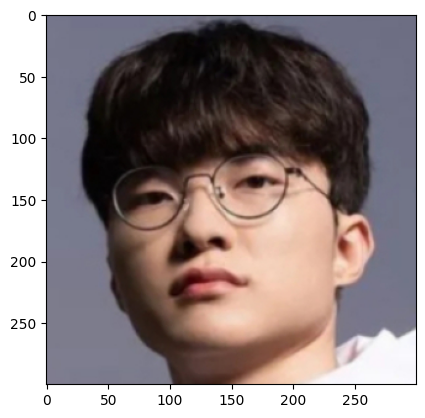

In [6]:
data_path = Path(data_path)
img_path_list = list(data_path.glob("*/*.jpg"))
random_img_path = random.choice(img_path_list)
random_label_img = random_img_path.parent.stem
img = Image.open(random_img_path)
print('random path :' , random_img_path)
print('lable random img :' , random_label_img)
print('kich thuoc:' , img.size)

plt.imshow(img)

In [7]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),

])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [8]:

def is_valid_file(path):
    allowed_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp', '.jfif')
    return path.lower().endswith(allowed_extensions)

print("Đang đọc dữ liệu (bao gồm cả jfif và webp)...")

dataset_raw = datasets.ImageFolder(root=data_path, is_valid_file=is_valid_file)

# Lấy nhãn
targets = np.array(dataset_raw.targets)

# Lọc lỗi(nếu có)
counts = collections.Counter(targets)
valid_indices = []
for idx, target in enumerate(targets):
    if counts[target] >= 2:
        valid_indices.append(idx)
    else:
        if idx == targets.tolist().index(target):
            print(f"⚠️ Vẫn cảnh báo: Loại bỏ lớp '{dataset_raw.classes[target]}' vì chỉ có {counts[target]} ảnh.")

valid_indices = np.array(valid_indices)
filtered_targets = targets[valid_indices]

# Chia Data
print(f"Tiến hành chia dữ liệu trên {len(valid_indices)} ảnh hợp lệ...")

train_idx_raw, test_idx_raw = train_test_split(
    valid_indices,
    test_size=0.3,
    shuffle=True,
    stratify=filtered_targets,
    random_state=42
)

#Tạo Dataset
train_dataset_source = datasets.ImageFolder(root=data_path, transform=train_transform, is_valid_file=is_valid_file)
test_dataset_source = datasets.ImageFolder(root=data_path, transform=test_transform, is_valid_file=is_valid_file)

train_data = Subset(train_dataset_source, train_idx_raw)
test_data = Subset(test_dataset_source, test_idx_raw)


print("-" * 30)
print(f"Tổng Train: {len(train_data)}")
print(f"Tổng Test: {len(test_data)}")


Đang đọc dữ liệu (bao gồm cả jfif và webp)...
Tiến hành chia dữ liệu trên 550 ảnh hợp lệ...
------------------------------
Tổng Train: 385
Tổng Test: 165


In [9]:

# Thêm drop_last=True vào DataLoader của tập TRAIN
minibatch_train = DataLoader(
    train_data,
    shuffle=True,
    batch_size=8,
    drop_last=True
)

minibatch_test = DataLoader(
    test_data,
    shuffle=True,
    batch_size=1
)

print("Đã khởi tạo lại DataLoader với drop_last=True")

Đã khởi tạo lại DataLoader với drop_last=True


tensor(19)


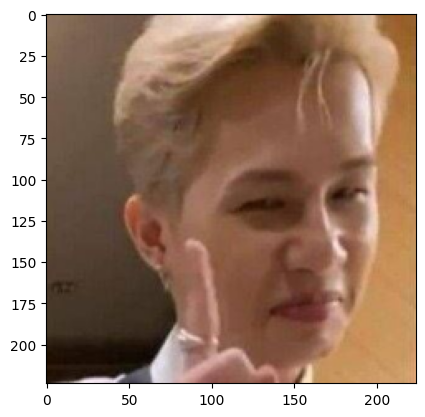

In [10]:
for index , e in enumerate(minibatch_test):
  label = e[1][0]
  img = e[0][0]
  break
plt.imshow(img.permute(1,2,0) )
print(label)

In [11]:
import torch.nn as nn
from torchvision import models

def make_model(class_count, lr=0.001):
    #Tải model MobileNetV2 "
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = True

    # Cải tiến
    # Lấy số channels đầu vào của lớp classifier cuối cùng
    in_features = model.last_channel

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(256, class_count)
    )

    model = model.to(device)

    print(f"Created MobileNetV2 model (PyTorch) with initial learning rate set to {lr}")

    return model

# Tham số
# Số lượng lớp
class_count = len(train_data.dataset.classes)

# Khởi tạo mô hình
lr = 0.001
model = make_model(class_count, lr)
optimizer = torch.optim.Adamax(model.parameters(), lr=lr, weight_decay=0.016)

# Loss Function
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 229MB/s]


Created MobileNetV2 model (PyTorch) with initial learning rate set to 0.001


In [12]:

epochs = 20
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("Bắt đầu huấn luyện...")

for epoch in range(epochs):

    #Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    loop = tqdm(minibatch_train, desc=f"Epoch {epoch+1}/{epochs} [Train]")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item())

    epoch_train_loss = running_loss / total_train
    epoch_train_acc = correct_train / total_train

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in minibatch_test:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / total_val
    epoch_val_acc = correct_val / total_val


    #KQ
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    print("-" * 70)

print("Hoàn tất huấn luyện!")

Bắt đầu huấn luyện...


Epoch 1/20 [Train]: 100%|██████████| 48/48 [08:02<00:00, 10.06s/it, loss=2.86]


Epoch [1/20] Train Loss: 3.1214 | Train Acc: 0.1354 | Val Loss: 2.6432 | Val Acc: 0.2970
----------------------------------------------------------------------


Epoch 2/20 [Train]: 100%|██████████| 48/48 [00:04<00:00, 10.18it/s, loss=2.37]


Epoch [2/20] Train Loss: 2.2905 | Train Acc: 0.4844 | Val Loss: 2.0703 | Val Acc: 0.5273
----------------------------------------------------------------------


Epoch 3/20 [Train]: 100%|██████████| 48/48 [00:05<00:00,  9.49it/s, loss=1.74]


Epoch [3/20] Train Loss: 1.8227 | Train Acc: 0.6979 | Val Loss: 1.8389 | Val Acc: 0.7030
----------------------------------------------------------------------


Epoch 4/20 [Train]: 100%|██████████| 48/48 [00:05<00:00,  9.59it/s, loss=1.47]


Epoch [4/20] Train Loss: 1.5297 | Train Acc: 0.7760 | Val Loss: 1.6053 | Val Acc: 0.7455
----------------------------------------------------------------------


Epoch 5/20 [Train]: 100%|██████████| 48/48 [00:04<00:00, 10.29it/s, loss=1.26]


Epoch [5/20] Train Loss: 1.2903 | Train Acc: 0.8411 | Val Loss: 1.4056 | Val Acc: 0.8000
----------------------------------------------------------------------


Epoch 6/20 [Train]: 100%|██████████| 48/48 [00:04<00:00, 11.48it/s, loss=0.867]


Epoch [6/20] Train Loss: 1.0552 | Train Acc: 0.9089 | Val Loss: 1.3759 | Val Acc: 0.8182
----------------------------------------------------------------------


Epoch 7/20 [Train]: 100%|██████████| 48/48 [00:04<00:00, 10.19it/s, loss=1.09]


Epoch [7/20] Train Loss: 0.9435 | Train Acc: 0.9245 | Val Loss: 1.2617 | Val Acc: 0.8242
----------------------------------------------------------------------


Epoch 8/20 [Train]: 100%|██████████| 48/48 [00:04<00:00, 11.45it/s, loss=0.981]


Epoch [8/20] Train Loss: 0.7659 | Train Acc: 0.9557 | Val Loss: 1.1620 | Val Acc: 0.8606
----------------------------------------------------------------------


Epoch 9/20 [Train]: 100%|██████████| 48/48 [00:04<00:00,  9.85it/s, loss=0.553]


Epoch [9/20] Train Loss: 0.6734 | Train Acc: 0.9714 | Val Loss: 1.1064 | Val Acc: 0.8242
----------------------------------------------------------------------


Epoch 10/20 [Train]: 100%|██████████| 48/48 [00:04<00:00, 11.62it/s, loss=0.507]


Epoch [10/20] Train Loss: 0.6162 | Train Acc: 0.9557 | Val Loss: 1.0506 | Val Acc: 0.8303
----------------------------------------------------------------------


Epoch 11/20 [Train]: 100%|██████████| 48/48 [00:04<00:00,  9.81it/s, loss=0.456]


Epoch [11/20] Train Loss: 0.5876 | Train Acc: 0.9766 | Val Loss: 1.0479 | Val Acc: 0.8242
----------------------------------------------------------------------


Epoch 12/20 [Train]: 100%|██████████| 48/48 [00:04<00:00, 11.25it/s, loss=0.549]


Epoch [12/20] Train Loss: 0.5207 | Train Acc: 0.9609 | Val Loss: 1.0123 | Val Acc: 0.8242
----------------------------------------------------------------------


Epoch 13/20 [Train]: 100%|██████████| 48/48 [00:05<00:00,  8.44it/s, loss=0.505]


Epoch [13/20] Train Loss: 0.4877 | Train Acc: 0.9766 | Val Loss: 1.0756 | Val Acc: 0.8242
----------------------------------------------------------------------


Epoch 14/20 [Train]: 100%|██████████| 48/48 [00:04<00:00, 11.28it/s, loss=0.548]


Epoch [14/20] Train Loss: 0.4616 | Train Acc: 0.9766 | Val Loss: 0.9939 | Val Acc: 0.8303
----------------------------------------------------------------------


Epoch 15/20 [Train]: 100%|██████████| 48/48 [00:04<00:00,  9.94it/s, loss=1.23]


Epoch [15/20] Train Loss: 0.4508 | Train Acc: 0.9766 | Val Loss: 0.9531 | Val Acc: 0.8545
----------------------------------------------------------------------


Epoch 16/20 [Train]: 100%|██████████| 48/48 [00:04<00:00, 11.68it/s, loss=0.312]


Epoch [16/20] Train Loss: 0.4600 | Train Acc: 0.9896 | Val Loss: 1.1319 | Val Acc: 0.7818
----------------------------------------------------------------------


Epoch 17/20 [Train]: 100%|██████████| 48/48 [00:04<00:00,  9.88it/s, loss=0.458]


Epoch [17/20] Train Loss: 0.4831 | Train Acc: 0.9766 | Val Loss: 0.9723 | Val Acc: 0.8182
----------------------------------------------------------------------


Epoch 18/20 [Train]: 100%|██████████| 48/48 [00:04<00:00, 11.31it/s, loss=0.425]


Epoch [18/20] Train Loss: 0.4168 | Train Acc: 0.9896 | Val Loss: 0.8979 | Val Acc: 0.8485
----------------------------------------------------------------------


Epoch 19/20 [Train]: 100%|██████████| 48/48 [00:04<00:00,  9.69it/s, loss=0.383]


Epoch [19/20] Train Loss: 0.4698 | Train Acc: 0.9688 | Val Loss: 1.0442 | Val Acc: 0.7939
----------------------------------------------------------------------


Epoch 20/20 [Train]: 100%|██████████| 48/48 [00:04<00:00, 11.58it/s, loss=0.511]


Epoch [20/20] Train Loss: 0.4117 | Train Acc: 0.9792 | Val Loss: 1.0969 | Val Acc: 0.7818
----------------------------------------------------------------------
Hoàn tất huấn luyện!


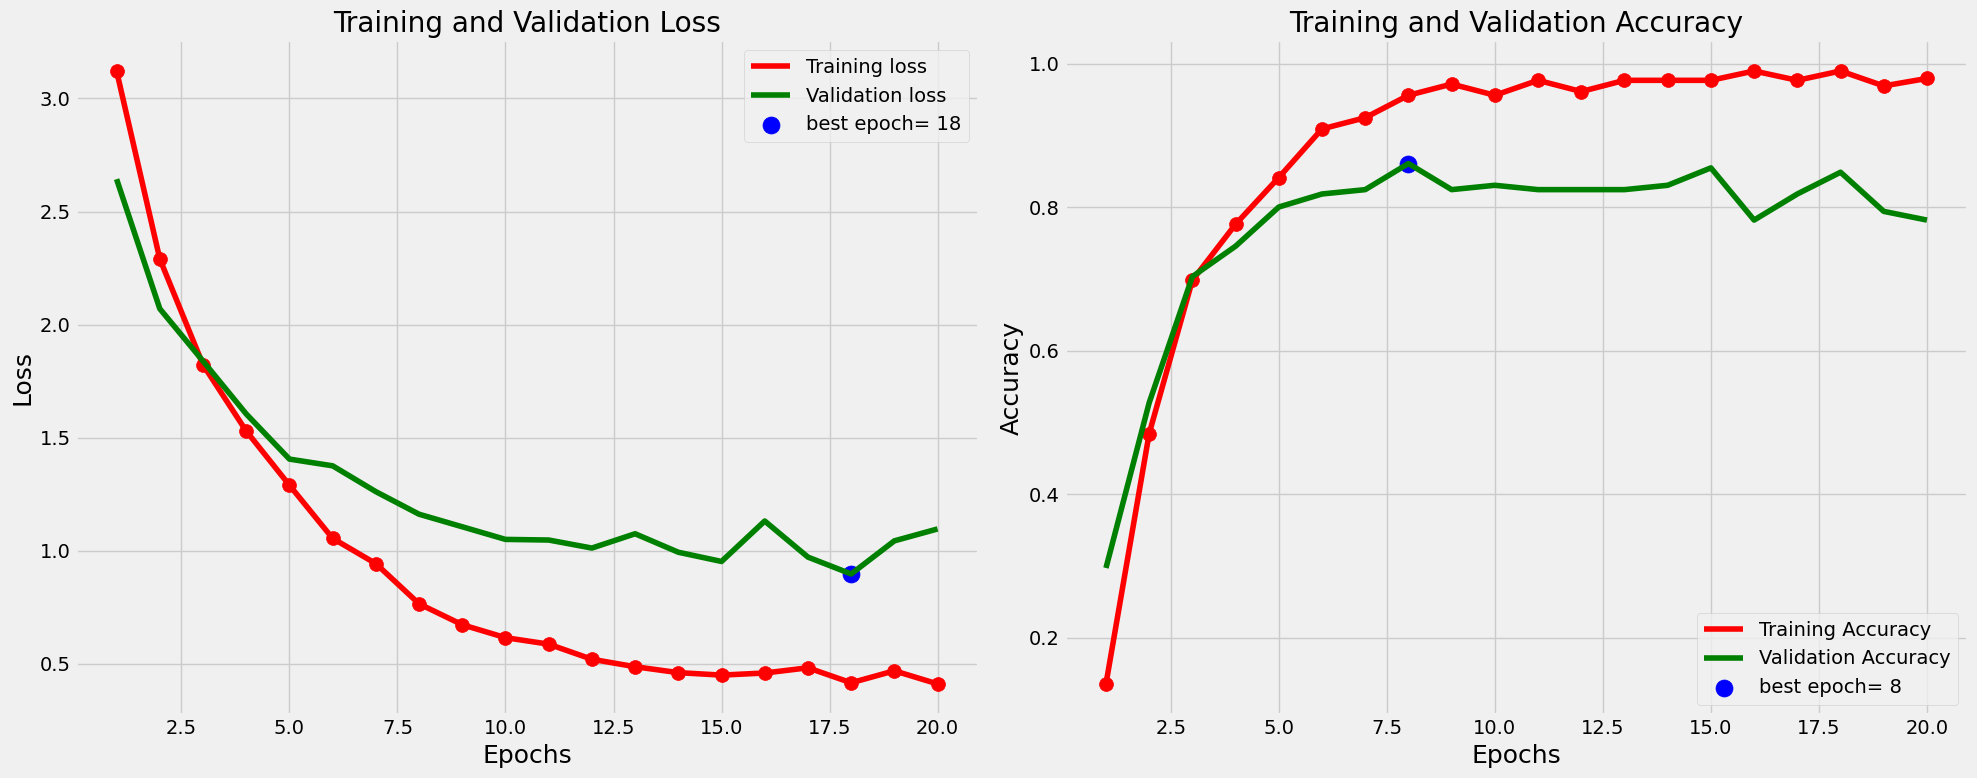

In [13]:

def tr_plot(tr_data):
    tacc = tr_data['train_acc']
    tloss = tr_data['train_loss']
    vacc = tr_data['val_acc']
    vloss = tr_data['val_loss']

    start_epoch = 0
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)

    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]

    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]


    plt.style.use('fivethirtyeight')


    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    # Biểu đồ
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red') # Dấu chấm đỏ trên đường train
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    # Accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


tr_plot(history)

Đang dự đoán trên 165 ảnh...
There were 36 errors in 165 tests for an accuracy of  78.18%


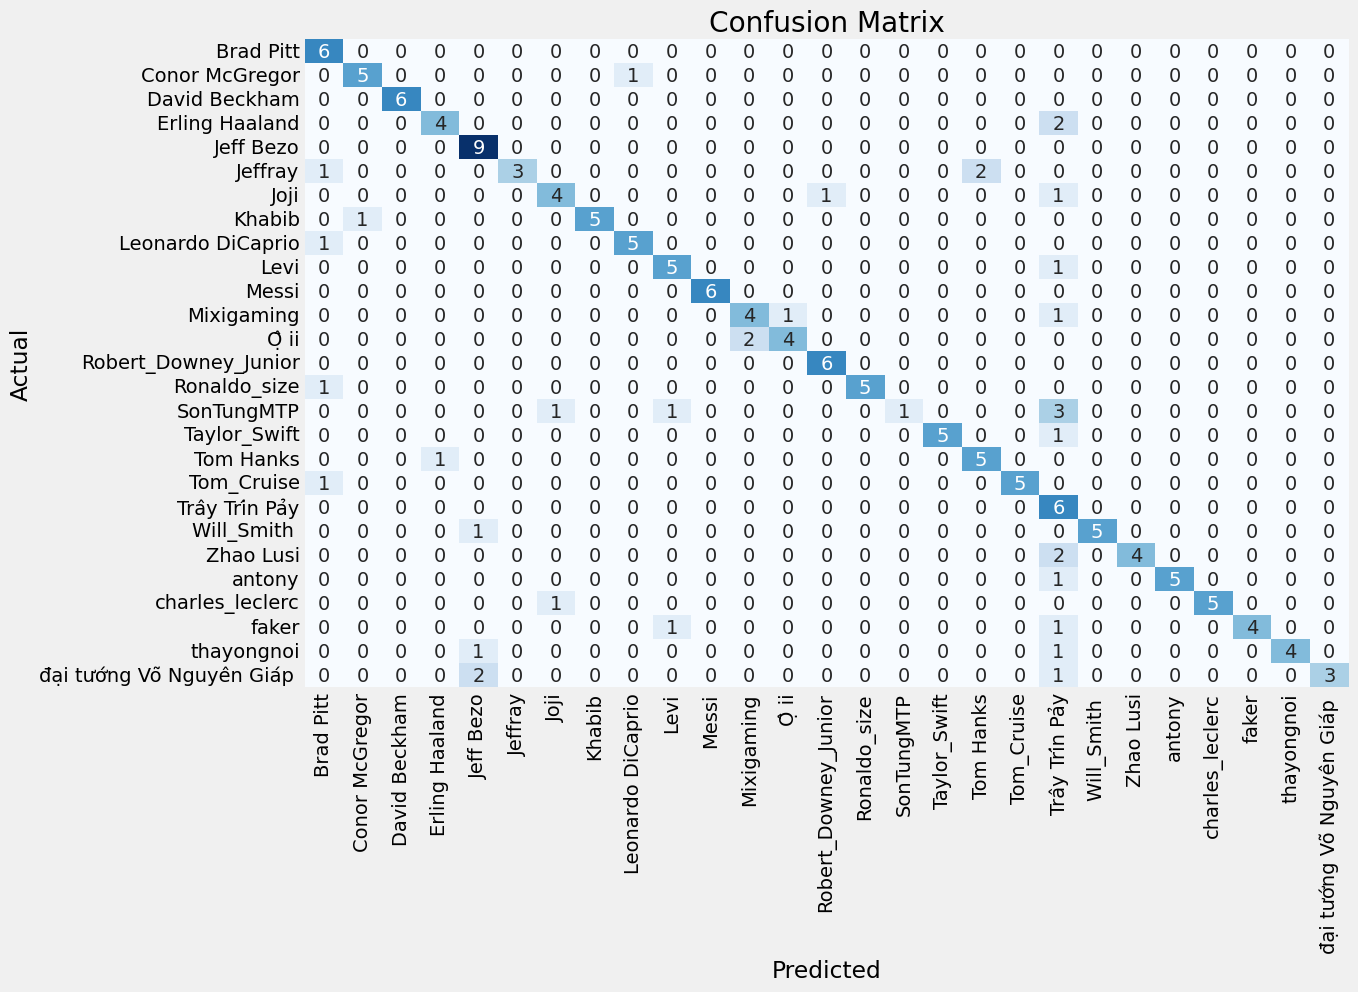

Classification Report:
----------------------
                                   precision    recall  f1-score   support

                       Brad Pitt     0.6000    1.0000    0.7500         6
                  Conor McGregor     0.8333    0.8333    0.8333         6
                   David Beckham     1.0000    1.0000    1.0000         6
                  Erling Haaland     0.8000    0.6667    0.7273         6
                       Jeff Bezo     0.6923    1.0000    0.8182         9
                         Jeffray     1.0000    0.5000    0.6667         6
                            Joji     0.6667    0.6667    0.6667         6
                          Khabib     1.0000    0.8333    0.9091         6
               Leonardo DiCaprio     0.8333    0.8333    0.8333         6
                            Levi     0.7143    0.8333    0.7692         6
                           Messi     1.0000    1.0000    1.0000         6
                      Mixigaming     0.6667    0.6667    0.6667 

In [14]:
def predictor(test_data, model):
    #CB data
    y_pred = []
    y_true = []
    error_list = []
    error_pred_list = []

    #Nhãn
    classes = test_data.dataset.classes
    class_count = len(classes)

    errors = 0
    tests = len(test_data)

    print(f"Đang dự đoán trên {tests} ảnh...")


    model.eval()

    # 2. Vòng lặp dự đoán
    # Chúng ta lặp trực tiếp qua từng phần tử của test_data (Subset)
    # để dễ dàng truy xuất đường dẫn file ảnh gốc
    with torch.no_grad():
        for i in range(tests):
            image, label = test_data[i]

            # Thêm chiều batch [3, 224, 224] -> [1, 3, 224, 224]
            image_input = image.unsqueeze(0).to(device)
            outputs = model(image_input)

            # Lấy index có xác suất cao nhất
            _, pred_tensor = torch.max(outputs, 1)
            pred_index = pred_tensor.item()

            # Lưu kết quả
            y_true.append(label)
            y_pred.append(pred_index)

            # 3. Kiểm tra lỗi
            if pred_index != label:
                errors += 1
                original_index = test_data.indices[i]
                path, _ = test_data.dataset.samples[original_index]

                error_list.append(path)
                error_pred_list.append(classes[pred_index])

    #TÍnh toán
    acc = (1 - errors / tests) * 100
    msg = f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%'
    print(msg)

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # Tính F1 Score
    f1score = f1_score(y_true, y_pred, average='weighted') * 100

    # Confusion Matrix
    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + 0.5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + 0.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    #Report
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return errors, tests, error_list, error_pred_list, f1score
errors, tests, error_list, error_pred_list, f1score = predictor(test_data, model)


🔍 KẾT QUẢ DỰ ĐOÁN CHI TIẾT (TEST SET)
• Nguồn dữ liệu      : TEST SET )
• Nhãn thực tế       : Leonardo DiCaprio
• Mô hình dự đoán    : Leonardo DiCaprio
• Độ tin cậy         : 96.48%
• Đánh giá chung     :  ĐÚNG



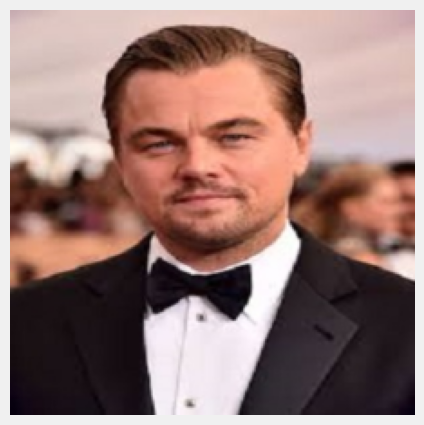

In [23]:


def predict_image_and_text(test_ds, model, device):
    # Lấy data
    dataset = test_ds
    rand_idx = random.randint(0, len(dataset) - 1)
    img_tensor, label_idx = dataset[rand_idx]

    try:
        class_names = dataset.classes
    except AttributeError:
        class_names = dataset.dataset.classes

    true_label = class_names[label_idx]

    #Predict
    input_tensor = img_tensor.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, pred_idx = torch.max(probabilities, 1)

        pred_label = class_names[pred_idx.item()]
        conf_score = confidence.item() * 100

    result_status = " ĐÚNG" if pred_label == true_label else " SAI"

    # KQ
    print("\n" + "="*45)
    print(f"🔍 KẾT QUẢ DỰ ĐOÁN CHI TIẾT (TEST SET)")
    print("="*45)
    print(f"• Nguồn dữ liệu      : TEST SET )")
    print(f"• Nhãn thực tế       : {true_label}")
    print(f"• Mô hình dự đoán    : {pred_label}")
    print(f"• Độ tin cậy         : {conf_score:.2f}%")
    print(f"• Đánh giá chung     : {result_status}")
    print("="*45 + "\n")


    plt.figure(figsize=(5, 5))
    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img_display)
    plt.axis('off')
    plt.show()

predict_image_and_text(test_data, model, device)

 Danh sách lớp mô hình đã học: ['Brad Pitt', 'Conor McGregor', 'David Beckham', 'Erling Haaland', 'Jeff Bezo', 'Jeffray', 'Joji', 'Khabib', 'Leonardo DiCaprio', 'Levi', 'Messi', 'Mixigaming', 'Ộ ii', 'Robert_Downey_Junior', 'Ronaldo_size', 'SonTungMTP', 'Taylor_Swift', 'Tom Hanks', 'Tom_Cruise', 'Trây Trín Pảy', 'Will_Smith ', 'Zhao Lusi', 'antony', 'charles_leclerc', 'faker', 'thayongnoi', 'đại tướng Võ Nguyên Giáp ']

🔮 DỰ ĐOÁN (ẢNH KHÔNG NHÃN)
• Ảnh đang xem : download (7).jpg
• Model dự đoán: faker
• Độ tin cậy   : 70.44%


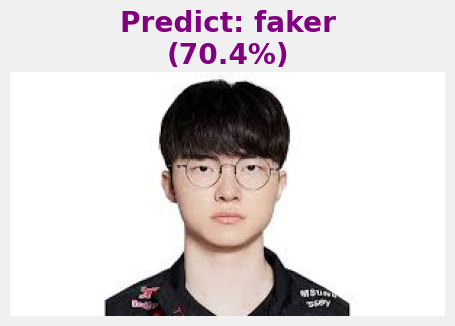

In [28]:

try:
    #Dataset thường
    if hasattr(test_data, 'classes'):
        class_names = test_data.classes
    # Subset
    elif hasattr(test_data, 'dataset') and hasattr(test_data.dataset, 'classes'):
        class_names = test_data.dataset.classes
    else:
        raise AttributeError
except (NameError, AttributeError):
    print("⚠️ Không tự lấy được tên lớp. Đang dùng danh sách mặc định.")


print(f" Danh sách lớp mô hình đã học: {class_names}")

# Lấy data
folder_path = '/content/drive/MyDrive/Deep_Learning/data_test'
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

#Predict
def predict_blindly(folder_path, model, transform, class_names, device):
    # Tìm tất cả file ảnh
    image_paths = []
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(valid_exts):
                image_paths.append(os.path.join(root, file))

    if not image_paths:
        print(f" Không tìm thấy ảnh nào trong: {folder_path}")
        return

    img_path = random.choice(image_paths)
    img_name = os.path.basename(img_path)

    img_pil = Image.open(img_path).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0).to(device) # [1, C, H, W]

    # Dự đoán
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, pred_idx = torch.max(probabilities, 1)

        pred_label = class_names[pred_idx.item()]
        conf_score = confidence.item() * 100

    # Hiển thị
    print("\n" + "="*40)
    print(f"🔮 DỰ ĐOÁN (ẢNH KHÔNG NHÃN)")
    print("="*40)
    print(f"• Ảnh đang xem : {img_name}")
    print(f"• Model dự đoán: {pred_label}")
    print(f"• Độ tin cậy   : {conf_score:.2f}%")
    print("="*40)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_pil)
    plt.axis('off')
    plt.title(f"Predict: {pred_label}\n({conf_score:.1f}%)", color='purple', fontweight='bold')
    plt.show()

# CHẠY
predict_blindly(folder_path, model, inference_transform, class_names, device)